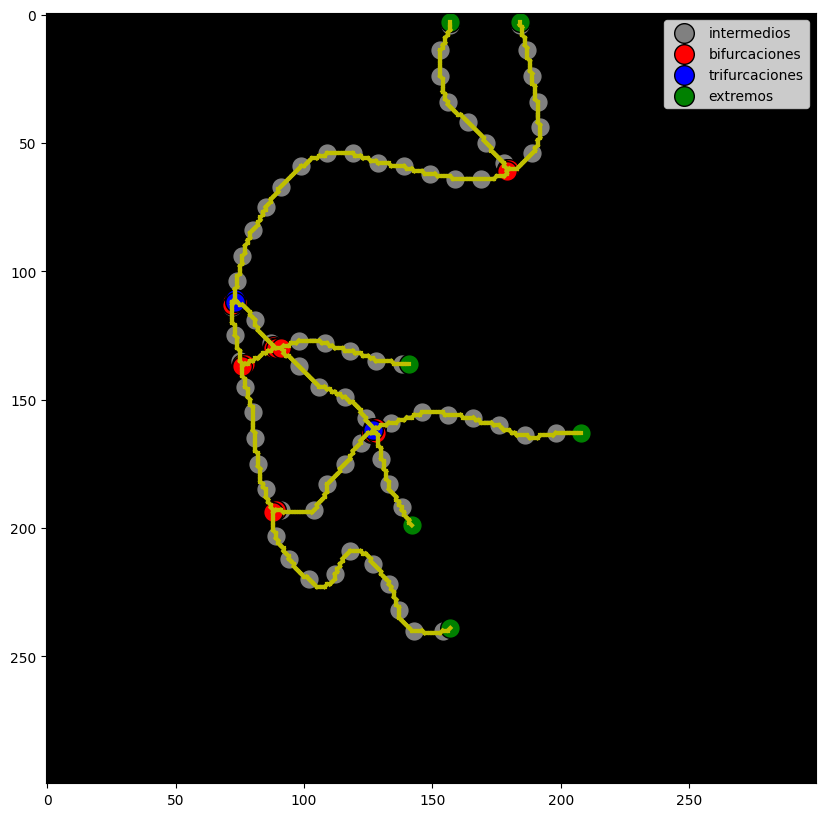

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.io import imread
from scipy.spatial import distance

def load_and_preprocess_image(img_path):
    """
    Carga la imagen y la binariza sin invertir los valores.

    Args:
        image_path (str): Ruta de la imagen a cargar.

    Returns:
        skeleton (np.ndarray): Imagen binarizada.
    """
    image = imread(img_path, as_gray=True)
    binary_image = image > 0.5
    skeleton = skeletonize(binary_image)  # Aplicar esqueletización

    return skeleton.astype(np.uint8)


def find_pixel_neighbors(img, x, y):
    """
    Obtiene los vecinos de un píxel en la imagen binaria.

    Args:
        img (np.ndarray): Imagen binarizada.
        x (int): Coordenada x del píxel.
        y (int): Coordenada y del píxel.

    Returns:
        neighbors (list): Lista de vecinos del píxel.
    """
    neighbors = [
        (x-1, y-1), (x-1, y), (x-1, y+1),
        (x,   y-1),           (x,   y+1),
        (x+1, y-1), (x+1, y), (x+1, y+1)
    ]

    # Filtrar vecinos válidos
    return [(i, j) for i, j in neighbors if 0 <= i < img.shape[0] and 0 <= j < img.shape[1] and img[i, j] == 1]


def detect_node_types(skeleton):
    """
    Clasifica los nodos en extremos, intermedios, bifurcaciones y trifurcaciones.
    
    Args:
        skeleton (np.ndarray): Imagen binarizada con esqueleto.

    Returns:
        nodes (dict): Diccionario con los nodos clasificados.
    """

    # Inicializar diccionario de nodos
    nodes = {"extremos": [], "bifurcaciones": [], "trifurcaciones": [], "intermedios": []}
    
    # Recorrer la imagen y clasificar los nodos
    for x in range(skeleton.shape[0]):
        for y in range(skeleton.shape[1]):
            if skeleton[x, y] == 1:
                # Contar vecinos del píxel actual
                neighbors = find_pixel_neighbors(skeleton, x, y)
                count = len(neighbors)
                
                if count == 1:
                    nodes["extremos"].append((x, y))
                elif count == 2:
                    nodes["intermedios"].append((x, y))
                elif count == 3:
                    nodes["bifurcaciones"].append((x, y))
                elif count >= 4:
                    nodes["trifurcaciones"].append((x, y))
    
    return nodes


def build_graph(skeleton):
    """
    Construye el grafo asegurando que solo haya conexiones entre vecinos directos.

    Args:
        skeleton (np.ndarray): Imagen binarizada con esqueleto.

    Returns:
        edges (list): Lista de aristas del grafo.
    """

    # Inicializar lista de aristas y conjunto de nodos visitados
    edges = []
    visited = set()
    
    # Recorrer la imagen y agregar aristas entre nodos vecinos
    for x in range(skeleton.shape[0]):
        for y in range(skeleton.shape[1]):
            # Si el píxel actual es parte del esqueleto
            if skeleton[x, y] == 1:
                # Encontrar vecinos del píxel actual
                neighbors = find_pixel_neighbors(skeleton, x, y)

                # Agregar aristas entre el píxel actual y sus vecinos
                for neighbor in neighbors:
                    # Si la arista no ha sido visitada
                    if (x, y, neighbor) not in visited and (neighbor[0], neighbor[1], (x, y)) not in visited:
                        edges.append(((x, y), neighbor))
                        visited.add((x, y, neighbor))
    
    return edges


def reduce_intermediate_nodes(nodes, min_distance=10):
    """
    Reduce la cantidad de nodos intermedios manteniendo la forma de la estructura arterial.
    
    Args:
        nodes (dict): Diccionario con los nodos clasificados.
        min_distance (int): Distancia mínima entre nodos intermedios.

    Returns:
        nodes (dict): Diccionario con los nodos clasificados
                      después de reducir los nodos intermedios.
    """
    # Filtrar nodos intermedios
    filtered_intermediates = []
    if not nodes["intermedios"]:
        return nodes

    # Agregar el primer nodo intermedio
    filtered_intermediates.append(nodes["intermedios"][0])
    
    # Filtrar nodos intermedios que cumplan con la distancia mínima
    for node in nodes["intermedios"][1:]:
        # Si la distancia entre el nodo actual y los nodos filtrados es mayor o igual a la distancia mínima
        # Agregar el nodo actual a la lista de nodos filtrados
        if all(distance.euclidean(node, existing_node) >= min_distance for existing_node in filtered_intermediates):
            filtered_intermediates.append(node)

    # Actualizar nodos intermedios
    nodes["intermedios"] = filtered_intermediates
    return nodes


def visualize_graph(skeleton, nodes, edges):
    """
    Dibuja el grafo siguiendo la convención correcta en el orden de visualización.

    Args:
        skeleton (np.ndarray): Imagen binarizada con esqueleto.
        nodes (dict): Diccionario con los nodos clasificados.
        edges (list): Lista de aristas del

    Returns:
        None
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(skeleton, cmap="gray")

    for (start, end) in edges:
        x_vals, y_vals = zip(*[start, end])
        plt.plot(y_vals, x_vals, "y-", linewidth=3)

    draw_order = [
        ("intermedios", "gray", 200),
        ("bifurcaciones", "red", 200),
        ("trifurcaciones", "blue", 200),
        ("extremos", "green", 200)
    ]

    for category, color, size in draw_order:
        if nodes[category]:
            x_vals, y_vals = zip(*nodes[category])
            plt.scatter(y_vals, x_vals, c=color, edgecolors='black', linewidth=1, label=category, s=size, marker='o')

    plt.legend()
    plt.show()


def main(image_path):
    skeleton = load_and_preprocess_image(image_path)
    neighbors = detect_node_types(skeleton)
    nodes = reduce_intermediate_nodes(neighbors, min_distance=10)
    edges = build_graph(skeleton)
    visualize_graph(skeleton, nodes, edges)


main("images/1_gt.pgm")